<a href="https://colab.research.google.com/github/Awerdos/Anomaly-Detection-with-AutoEncoder/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import torch
import pandas as pd
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [45]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5),(0.5))])

batch_size = 4

dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=transform)
data = dataset.data

mask_normal = np.where(dataset.targets == 4)[0]
mask_anomaly = np.where(dataset.targets != 4)[0]

trainset = torch.utils.data.Subset(dataset, mask_normal)
testset = torch.utils.data.Subset(dataset, mask_anomaly)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

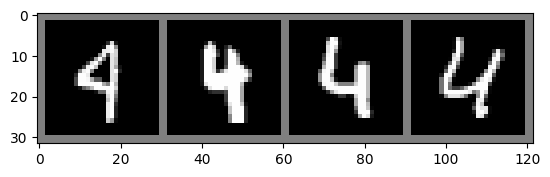

In [46]:
def imshow(img):
  img = img/2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [ ]:
import torch.nn as nn
import torch.nn.functional as Act

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 7)
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid()
    )

  def forward(self,x):
    compressed = self.encoder(x)
    decompressed - self.decoder(compressed)
    return decompressed




In [ ]:
import torch.optim as optim

model = AutoEncoder()
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)